In [40]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from tqdm import tqdm

In [44]:
basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

In [5]:
sn9 = arepo.Snapshot('../MW4iso_fg0.2_MHG0.25_RC9/lvl4/MW.hdf5')
sn20 = arepo.Snapshot('lvl4/MW.hdf5')

In [16]:
R200 = 129
center = np.array([200, 200, 200])

In [17]:
r9 = {}
r20 = {}
for ptype in [0, 1, 2, 3]:
    part = getattr(sn9, 'part'+str(ptype))
    r9[ptype] = np.linalg.norm(part.pos - center, axis=1)
    
    part = getattr(sn20, 'part'+str(ptype))
    r20[ptype] = np.linalg.norm(part.pos - center, axis=1)

In [25]:
M9 = {}
M20 = {}
for ptype in [0, 1, 2, 3]:
    if ptype==0:
        is_CGM = sn9.part0.GFM_Metallicity < 0.1
        is_disk = np.logical_not(is_CGM)
        in_R200 = r9[ptype] < R200
        
        M9[ptype] = np.sum(sn9.part0.mass[np.logical_and(is_disk, in_R200)])
        M9[5] = np.sum(sn9.part0.mass[np.logical_and(is_CGM, in_R200)])
        
        is_CGM = sn20.part0.GFM_Metallicity < 0.1
        is_disk = np.logical_not(is_CGM)
        in_R200 = r20[ptype] < R200
        
        M20[ptype] = np.sum(sn20.part0.mass[np.logical_and(is_disk, in_R200)])
        M20[5] = np.sum(sn20.part0.mass[np.logical_and(is_CGM, in_R200)])
        
    else:
        M9[ptype] = sn9.MassTable[ptype] * len(np.where(r9[ptype] < R200)[0])
        M20[ptype] = sn20.MassTable[ptype] * len(np.where(r20[ptype] < R200)[0])
    

In [26]:
print(M9)
print(M20)

{0: 0.14974424, 5: 1.1315107, 1: 20.80121724553969, 2: 0.5989770193023859, 3: 0.7950672396517584}
{0: 0.14974424, 5: 1.0002873, 1: 20.80121724553969, 2: 0.5989770193023859, 3: 0.7950619852579097}


In [30]:
is_CGM = sn9.part0.GFM_Metallicity < 0.1
is_disk = np.logical_not(is_CGM)
in_R200 = r9[0] < 5
        
# M9[ptype] = np.sum(sn9.part0.mass[np.logical_and(is_disk, in_R200)])
print(np.sum(sn9.part0.mass[np.logical_and(is_CGM, in_R200)]))
        
is_CGM = sn20.part0.GFM_Metallicity < 0.1
is_disk = np.logical_not(is_CGM)
in_R200 = r20[0] < 5
        
# M20[ptype] = np.sum(sn20.part0.mass[np.logical_and(is_disk, in_R200)])
print(np.sum(sn20.part0.mass[np.logical_and(is_CGM, in_R200)]))

0.0042910967
0.00090022996


In [31]:
def get_CGM_dens_profile(sn, center=np.array([200, 200, 200])):
    is_CGM = sn.part0.GFM_Metallicity < 0.1
    r = np.linalg.norm(sn.part0.pos-center, axis=1)
    
    rmin = 0
    dr = 1
    rmax = 200
    
    rho = []
    aver = []
    
    while rmin < rmax:
        in_shell = np.logical_and(r > rmin, r < rmin + dr)
        key = np.logical_and(in_shell, is_CGM)
        Menc = np.sum(sn.part0.mass[key])
        vol = (4 * np.pi/3.) * ((rmin+dr)**3 - rmin**3)
        
        rho.append(Menc/vol)
        aver.append(np.mean(r[key]))
        
        rmin += dr
    
    return aver, rho
    

In [32]:
aver9, rho9 = get_CGM_dens_profile(sn9)
aver20, rho20 = get_CGM_dens_profile(sn20)

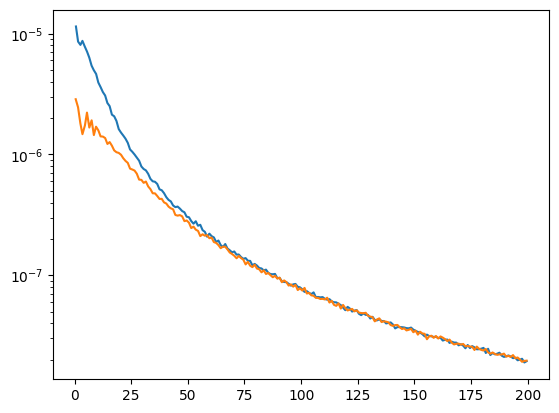

In [37]:
plt.plot(aver9, rho9)
plt.plot(aver20, rho20)
plt.yscale('log')

In [47]:
def accretion_rate(sn, r0, dr, COM, COMV):
    
    pos = sn.part0.pos.value - COM
    vel = sn.part0.vel.value - COMV
    mass = sn.part0.mass.value
    
    r = np.linalg.norm(pos, axis=1)
    R = np.linalg.norm(pos[:,:2], axis=1)
    cphi = pos[:,0]/R
    sphi = pos[:,1]/R
    ctheta = pos[:,2]/r
    stheta = np.sqrt(1 - ctheta**2)
    
    vr = stheta * cphi * vel[:,0] + stheta * sphi * vel[:,1] + ctheta * vel[:,2]
    
    key = np.logical_and(r > r0 - dr/2., r < r0 + dr/2.)
    keyin = np.logical_and(key, vr < 0)
    keyout = np.logical_and(key, vr > 0)
    
    Mdotin = np.sum(mass[keyin] * vr[keyin]) / dr
    Mdotout = np.sum(mass[keyout] * vr[keyout]) / dr
    
    Time = sn.Time.value
    
    return Time, Mdotin, Mdotout

In [46]:
sn9 = {}
sn20 = {}
num_list = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]
for num in tqdm(num_list):
    try:
        sn9[num] = arepo.Snapshot(basepath + 'runs/MW4iso_fg0.2_MHG0.25_RC9/lvl4/output', num, parttype=0,
                                 fields = ['Coordinates', 'Velocities', 'Masses'],
                                 combineFiles=True)
    except:
        pass
    
    try:
        sn20[num] = arepo.Snapshot(basepath + 'runs/MW4iso_fg0.2_MHG0.25_RC20/lvl4/output', num, parttype=0,
                                 fields = ['Coordinates', 'Velocities', 'Masses'],
                                    combineFiles=True)
    except:
        pass

100%|██████████| 13/13 [00:35<00:00,  2.74s/it]


In [51]:
Mdotin = {}
Mdotout = {}
Time = {}

Mdotin[9] = []
Mdotout[9] = []
Time[9] = []

Mdotin[20] = []
Mdotout[20] = []
Time[20] = []

center = np.array([200, 200, 200])
r0 = 20
dr = 2

for num in num_list:
    if num in sn9.keys():
        Time_, Mdotin_, Mdotout_ = accretion_rate(sn9[num], r0, dr, center, np.array([0, 0, 0]))
        Mdotin[9].append(Mdotin_)
        Mdotout[9].append(Mdotout_)
        Time[9].append(Time_)
        
    if num in sn20.keys():
        Time_, Mdotin_, Mdotout_ = accretion_rate(sn20[num], r0, dr, center, np.array([0, 0, 0]))
        Mdotin[20].append(Mdotin_)
        Mdotout[20].append(Mdotout_)
        Time[20].append(Time_)

/tmp/ipykernel_1142357/2771986783.py:9: RuntimeWarning: invalid value encountered in divide
  cphi = pos[:,0]/R
/tmp/ipykernel_1142357/2771986783.py:10: RuntimeWarning: invalid value encountered in divide
  sphi = pos[:,1]/R
/tmp/ipykernel_1142357/2771986783.py:11: RuntimeWarning: invalid value encountered in divide
  ctheta = pos[:,2]/r


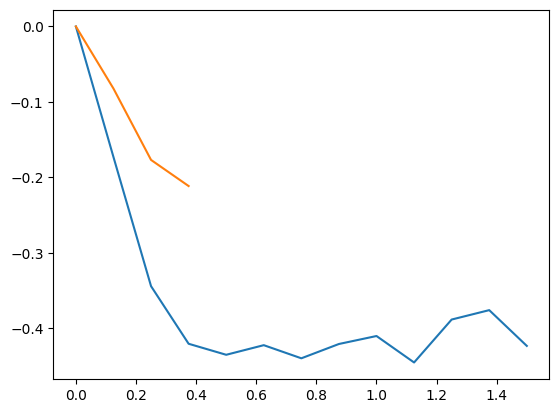

In [57]:
plt.plot(Time[9], Mdotin[9])
plt.plot(Time[20], Mdotin[20])